In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 24 kB/s 
     |████████████████████████████████| 199 kB 45.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4240c03d838bfb3535c34b26026c7b1d79b944069cc5900d54677e7b699933a7
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.spatial
import random
from pyspark import SparkConf, SparkContext
from matplotlib.pyplot import cm
from sklearn.datasets import make_blobs
import networkx as nx
from sklearn.metrics import classification_report
import time
from collections import Counter
from copy import deepcopy

# Data generation

In [3]:
def plot_clusters(ax, vertex_coordinates, labels=None):
    if labels is None:
        ax.scatter(vertex_coordinates[:, 0], vertex_coordinates[:, 1], s=10, alpha=0.6)
    else:
        cluster_labels = np.unique(labels)
        num_clusters = len(np.where(cluster_labels >= 0)[0])

        colors = iter(cm.rainbow(np.linspace(0, 1, num_clusters)))

        for label in cluster_labels:
            indices = np.where(labels == label)

            if label == -1:
                ax.scatter(vertex_coordinates[indices, 0], vertex_coordinates[indices, 1], s=10, alpha=0.6, color='lightblue', label='Outliers')
            else:
                ax.scatter(vertex_coordinates[indices, 0], vertex_coordinates[indices, 1], s=10, alpha=0.6, color=next(colors), label=f'Cluster {label}')

        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [4]:
X, y, centers = make_blobs(n_samples=2000, centers=3, cluster_std=0.8, shuffle=False, random_state=0, return_centers=True)

cluster_labels = np.unique(y)

In [5]:
print(X)
print(y)
print(cluster_labels)

[[ 1.73634081  4.18270156]
 [ 0.893695    4.63226613]
 [ 1.09150494  5.46720613]
 ...
 [-1.03622468  4.39284224]
 [-1.31003123  3.82704036]
 [-2.91756951  3.48359006]]
[0 0 0 ... 2 2 2]
[0 1 2]


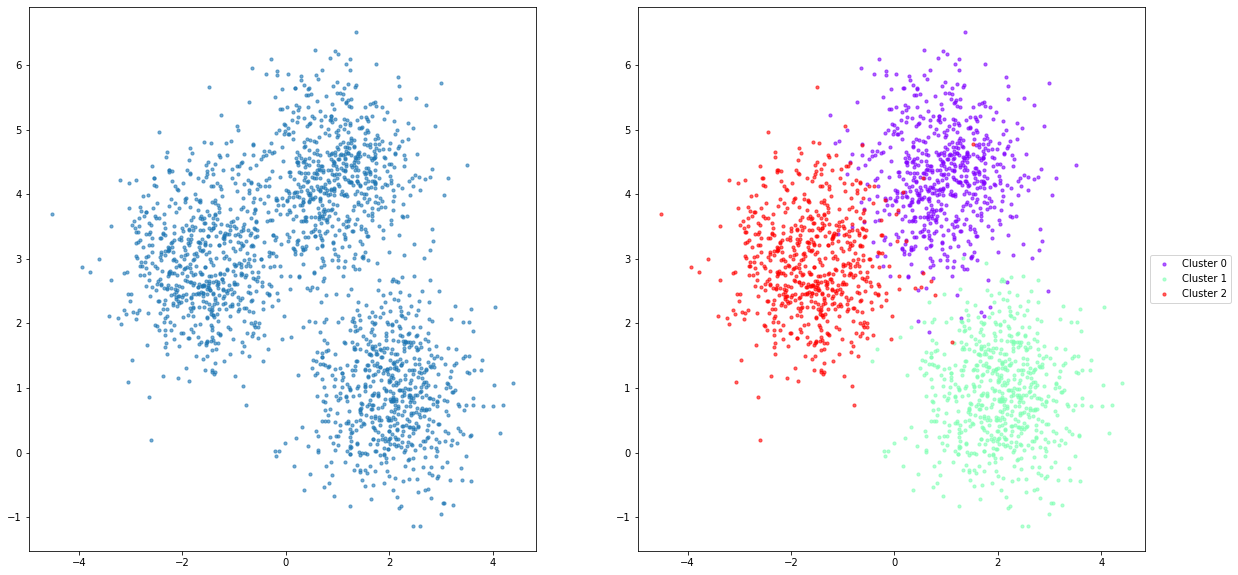

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_clusters(axes[0], X)
plot_clusters(axes[1], X, y)
plt.show()

# MST for dense graph

In [7]:
def create_distance_matrix(vertex_coordinates):
    """
    Creates the distance matrix for a dataset with only vertices. Also adds the edges to a dict.
    :param dataset: dataset without edges
    :return: distance matrix, a dict of all edges and the total number of edges
    """
    size = 0
    d_matrix = scipy.spatial.distance_matrix(vertex_coordinates, vertex_coordinates, threshold=1000000)
    dm = {}

    # Run with less edges
    for i in range(len(d_matrix)):
        dm2 = {}
        for j in range(i, len(d_matrix)):
            if i != j:
                size += 1
                dm2[j] = d_matrix[i][j]
        dm[i] = dm2

    return dm, size

In [8]:
def partition_vertices(vertices, k):
    """
    Partitioning of the vertices in k smaller subsets (creates a partitioning twice
    :param vertices: all vertices
    :param k: number of subsets that need to be created
    :return: the partitioning in list format
    """
    U = []
    V = []
    random.shuffle(vertices)
    verticesU = vertices.copy()
    random.shuffle(vertices)
    verticesV = vertices.copy()
    for i in range(len(vertices)):
        if i < k:
            U.append({verticesU[i]})
            V.append({verticesV[i]})
        else:
            U[i % k].add(verticesU[i])
            V[i % k].add(verticesV[i])
    return U, V

In [9]:
def get_key(item):
    """
    returns the sorting criteria for the edges. All edges are sorted from small to large values
    :param item: one item
    :return: returns the weight of the edge
    """
    return item[2]

In [10]:
def find_mst(U, V, E):
    """
    finds the mst of graph G = (U union V, E)
    :param U: vertices U
    :param V: vertices V
    :param E: edges of the graph
    :return: the mst and edges not in the mst of the graph
     """
    vertices = set()
    for v in V:
        vertices.add(v)
    for u in U:
        vertices.add(u)
    E = sorted(E, key=get_key)
    connected_component = set()
    mst = []
    remove_edges = set()
    while len(mst) < len(vertices) - 1 and len(connected_component) < len(vertices):
        if len(E) == 0:
            break
        change = False
        i = 0
        while i < len(E):
            if len(connected_component) == 0:
                connected_component.add(E[i][0])
                connected_component.add(E[i][1])
                mst.append(E[i])
                change = True
                E.remove(E[i])
                break
            else:
                if E[i][0] in connected_component:
                    if E[i][1] in connected_component:
                        remove_edges.add(E[i])
                        E.remove(E[i])
                    else:
                        connected_component.add(E[i][1])
                        mst.append(E[i])
                        E.remove(E[i])
                        change = True
                        break
                elif E[i][1] in connected_component:
                    if E[i][0] in connected_component:
                        remove_edges.add(E[i])
                        E.remove(E[i])
                    else:
                        connected_component.add(E[i][0])
                        mst.append(E[i])
                        E.remove(E[i])
                        change = True
                        break
                else:
                    i += 1
        if not change:
            if len(E) != 0:
                connected_component.add(E[0][0])
                connected_component.add(E[0][1])
                mst.append(E[0])
                E.remove(E[0])
    for edge in E:
        remove_edges.add(edge)
    if len(mst) != len(vertices) - 1 or len(connected_component) != len(vertices):
        print('Warning: parition cannot have a full MST! Missing edges to create full MST.')
        # print('Error: MST found cannot be correct \n Length mst: ', len(mst), '\n Total connected vertices: ',
        #       len(connected_component), '\n Number of vertices: ', len(vertices))
    return mst, remove_edges

In [11]:
def get_edges(U, V, E):
    """
    :param U: subset of vertices (u_j)
    :param V: subset of vertices (v_i)
    :param E: all edges of the whole graph
    :return: all edges that are part of the graph u_j U v_j
    """
    edges = set()
    for node1 in U:
        for node2 in V:
            if node1 in E:
                if node2 in E[node1]:
                    edges.add((node1, node2, E[node1][node2]))
                elif node2 in E:
                    if node1 in E[node2]:
                        edges.add((node2, node1, E[node2][node1]))
            elif node2 in E:
                if node1 in E[node2]:
                    edges.add((node2, node1, E[node2][node1]))
    edge_list = []
    for edge in edges:
        edge_list.append(edge)
    return U, V, edge_list

In [12]:
def reduce_edges(vertices, E, c, epsilon):
    """
    Uses PySpark to distribute the computation of the MSTs,
    Randomly partition the vertices twice in k subsets (U = {u_1, u_2, .., u_k}, V = {v_1, v_2, .., v_k})
    For every intersection between U_i and V_j, create the subgraph and find the MST in this graph
    Remove all edges from E that are not part of the MST in the subgraph
    :param vertices: vertices in the graph
    :param E: edges of the graph
    :param c: constant
    :param epsilon:
    :return:The reduced number of edges
    """
    conf = SparkConf().setAppName('MST_Algorithm')
    sc = SparkContext.getOrCreate(conf=conf)

    n = len(vertices)
    k = math.ceil(n ** ((c - epsilon) / 2))
    print('Number of buckets: ', k)
    U, V = partition_vertices(vertices, k)

    rddUV = sc.parallelize(U).cartesian(sc.parallelize(V)).map(lambda x: get_edges(x[0], x[1], E)).map(
        lambda x: (find_mst(x[0], x[1], x[2])))
    both = rddUV.collect()

    mst = []
    removed_edges = set()
    for i in range(len(both)):
        mst.append(both[i][0])
        for edge in both[i][1]:
            removed_edges.add(edge)

    sc.stop()
    return mst, removed_edges

In [13]:
def remove_edges(E, removed_edges):
    """
    Removes the edges, which are removed when generating msts
    :param E: current edges
    :param removed_edges: edges to be removed
    :return: return the updated edge dict
    """
    for edge in removed_edges:
        if edge[1] in E[edge[0]]:
            del E[edge[0]][edge[1]]
    return E

In [14]:
def create_mst(V, E, epsilon, size):
    """
    Creates the mst of the graph G = (V, E).
    As long as the number of edges is greater than n ^(1 + epsilon), the number of edges is reduced
    Then the edges that needs to be removed are removed from E and the size is updated.
    :param V: Vertices
    :param E: edges
    :param epsilon:
    :param size: number of edges
    :return: returns the reduced graph with at most np.power(n, 1 + epsilon) edges
    """
    print('Start creating MST...')
    timestamp = time.time()

    times = {}

    n = len(V)
    c = math.log(size / n, n)

    E = deepcopy(E)

    total_runs = 0
    while size > np.power(n, 1 + epsilon):
        total_runs += 1

        print('Communication round: ', total_runs)
        timestamp1 = time.time()

        print("c: ", c)

        mst, removed_edges = reduce_edges(V, E, c, epsilon)
        E = remove_edges(E, removed_edges)
        size = size - len(removed_edges)
        c = (c - epsilon) / 2

        round_time = time.time() - timestamp1
        times[f"round_{total_runs}"] = round_time

        print('Total number of edges removed in this round: ', len(removed_edges))
        print('New total number of edges: ', size)
        print('Round time: ', round_time)

    # Now the number of edges is reduced and can be moved to a single machine
    V = set(range(n))
    items = E.items()  # returns [(x, {y : 1})]
    edges = []
    for item in items:
        items2 = item[1].items()
        for item2 in items2:
            edges.append((item[0], item2[0], item2[1]))
    mst, removed_edges = find_mst(V, V, edges)

    total_time = time.time() - timestamp
    times['total'] = total_time

    print('Total rounds of communication: ', total_runs)
    print('MST size: ', len(mst))
    print('Created MST in: ', total_time)

    return mst, times 

# Clustering

In [15]:
def create_clusters_from_mst(mst, cluster_labels, min_cluster_size=1):
    print('Start creating clusters from MST...')
    timestamp = time.time()

    num_clusters = len(cluster_labels)

    # sort edge in mst by largest weight
    edges = sorted(mst, key=get_key, reverse=True)

    removed_edges = []
    clusters = []

    # magic
    while True:
        # remove largest edge
        edge = edges.pop(0)
        removed_edges.append(edge)

        # build the clusters
        graph = nx.Graph()
        graph.add_weighted_edges_from(edges)
        clusters = nx.connected_components(graph)

        # only accept clusters with size >= min_cluster_size, treat points from other clusters as outliers
        new_clusters = []

        for cluster in clusters:
            if len(cluster) >= min_cluster_size:
                new_clusters.append(list(cluster))

        clusters = new_clusters

        # repeat until enough clusters
        if (len(clusters) == num_clusters):
            break
    
    # sort vertices in a cluster 
    for cluster in clusters:
        cluster.sort()
    # sort clusters by the middle vertex
    clusters.sort(key=lambda x: x[(len(x) // 2) - 1])

    labeled_vertices = [[vertex, cluster_labels[i]] for i, cluster in enumerate(clusters) for vertex in cluster]
    labeled_vertices = np.array(labeled_vertices)

    labels = np.full(len(mst) + 1, -1)
    labels[labeled_vertices[:, 0]] = labeled_vertices[:, 1]

    elapsed_time = time.time() - timestamp
    print('Created clusters in: ', elapsed_time)

    return clusters, labels, removed_edges, elapsed_time

In [16]:
def plot_clusters_from_mst(ax, clusters, mst, vertex_coordinates, labels, removed_edges):
    x = vertex_coordinates[:, 0]
    y = vertex_coordinates[:, 1]

    plot_clusters(ax, vertex_coordinates, labels)

    for i in range(len(mst)):
        if mst[i] in removed_edges:
            continue

        linex = [x[mst[i][0]], x[mst[i][1]]]
        liney = [y[mst[i][0]], y[mst[i][1]]]
        
        for j, cluster in enumerate(clusters):
            if mst[i][0] in cluster:
                ax.plot(linex, liney, 'k', zorder=1, lw=1)

# Demo

In [ ]:
E, size = create_distance_matrix(X)
V = list(range(len(X)))

In [ ]:
mst, _ = create_mst(V, E, 1/8, size)

Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973469
New total number of edges:  25531
Round time:  78.12473750114441
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21953
New total number of edges:  3578
Round time:  7.062854766845703
Total rounds of communication:  2
MST size:  1999
Created MST in:  97.2488465309143


In [ ]:
clusters, y_hat, removed_edges, _ = create_clusters_from_mst(mst, cluster_labels, min_cluster_size=20)

Start creating clusters from MST...
Created clusters in:  1.6515166759490967


In [ ]:
counter = Counter(y_hat)
print(sorted(counter.items()))
print(classification_report(y, y_hat, labels=cluster_labels, digits=4))

[(-1, 370), (0, 511), (1, 552), (2, 567)]
              precision    recall  f1-score   support

           0     0.9785    0.7496    0.8489       667
           1     0.9873    0.8171    0.8942       667
           2     0.9683    0.8243    0.8905       666

   micro avg     0.9779    0.7970    0.8782      2000
   macro avg     0.9780    0.7970    0.8779      2000
weighted avg     0.9780    0.7970    0.8779      2000



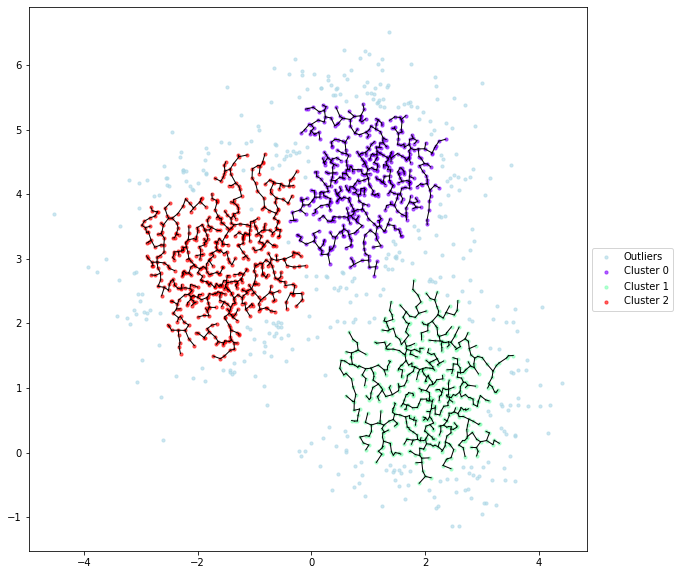

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_clusters_from_mst(ax, clusters, mst, X, y_hat, removed_edges)
plt.show()

# Experiments

In [19]:
def run_experiments(params):
    total_create_mst_times = []
    total_create_clusters_times = []
    total_performance = []
    
    for value in params[params['experiment']]:
        n_samples = params['n_samples']
        n_clusters = value if params['experiment'] == 'n_clusters' else params['n_clusters']
        cluster_std = value if params['experiment'] == 'cluster_std' else params['cluster_std']
        n_mst_runs = params['n_mst_runs']
        epsilon = params['epsilon']
        min_cluster_size = value if params['experiment'] == 'min_cluster_size' else params['min_cluster_size']
    
        print('==========')
        # generate data
        print('Start generating data...')
    
        X, y = make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=cluster_std, shuffle=False, random_state=0)
        
        cluster_labels = np.unique(y)
    
        print('Finished generating data.')
    
        # plot data
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        plot_clusters(axes[0], X)
        axes[0].set_title('Raw')
        plot_clusters(axes[1], X, y)
        axes[1].set_title('Labeled')
        fig.suptitle(f"n_samples={n_samples}, n_clusters={n_clusters}, cluster_std={cluster_std}", fontsize=16)
        plt.show()
    
        # create dense graph
        print('Start creating dense graph...')
    
        E, size = create_distance_matrix(X)
        V = list(range(len(X)))
    
        print('Number of vertices: ', len(V))
        print('Number of edges: ', size)
        print('Finished creating dense graph.')
    
        # we need to run the mst algo N_RUNS times because it is a randomized algo
        # then we report the macro-averaging statistics (running time, precision, recall, f1) of multiple runs
        # use macro-averaging because simple and labels are balanced
    
        create_mst_times = []
        create_clusters_times = []
        performance = []
    
        for run in range(n_mst_runs):
            print('=====')
            print('Run: ', run)
    
            # create mst from dense graph
            mst, times = create_mst(V, E, epsilon=epsilon, size=size)
            create_mst_times.append([times['round_1'], times['round_2'], times['total']])
    
            # create clusters from mst
            clusters, y_hat, removed_edges, t = create_clusters_from_mst(mst, cluster_labels, min_cluster_size=min_cluster_size)
            create_clusters_times.append(t)
    
            # measure clustering performance
            print('Clustering performance:')
    
            print(classification_report(y, y_hat, labels=cluster_labels, digits=4))
            report = classification_report(y, y_hat, labels=cluster_labels, digits=4, output_dict=True)
            performance.append([report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']])
    
        print('=====')
    
        avg_create_mst_times = np.mean(create_mst_times, axis=0).tolist()
        total_create_mst_times.append(avg_create_mst_times)
    
        avg_create_clusters_time = np.mean(create_clusters_times)
        total_create_clusters_times.append(avg_create_clusters_time)
    
        avg_performance = np.mean(performance, axis=0).tolist()
        total_performance.append(avg_performance)
    
        print('Average create_mst_round_1 time: ', avg_create_mst_times[0])
        print('Average create_mst_round_2 time: ', avg_create_mst_times[1])
        print('Average create_mst_total time: ', avg_create_mst_times[2])
        print('Average create_clusters time: ', avg_create_clusters_time)
        print('Average precision: ', avg_performance[0])
        print('Average recall: ', avg_performance[1])
        print('Average f1-score: ', avg_performance[2])
    
        # plot clusters from last run
        fig, ax = plt.subplots(figsize=(10, 10))
        plot_clusters_from_mst(ax, clusters, mst, X, y_hat, removed_edges)
        plt.show()
    
    total_create_mst_times = np.array(total_create_mst_times)
    total_create_clusters_times = np.array(total_create_clusters_times)
    total_performance = np.array(total_performance)

    return {'create_mst_times': total_create_mst_times, 'create_clusters_times': total_create_clusters_times, 'performance': total_performance}

In [20]:
def plot_time_analysis(axes, stats, params):
    axes[0].plot(params[params['experiment']], stats['create_mst_times'][:, 0], label='Round 1')
    axes[0].plot(params[params['experiment']], stats['create_mst_times'][:, 1], label='Round 2')
    axes[0].plot(params[params['experiment']], stats['create_mst_times'][:, 2], label='Total')
    axes[0].set_title('MST creation from dense graph')
    axes[0].set_xlabel(params['experiment'])
    axes[0].set_ylabel('Time (s)')
    axes[0].set_xticks(params[params['experiment']])
    axes[0].legend()
    
    axes[1].plot(params[params['experiment']], stats['create_clusters_times'])
    axes[1].set_title('Clusters creation from MST')
    axes[1].set_xlabel(params['experiment'])
    axes[1].set_ylabel('Time (s)')
    axes[1].set_xticks(params[params['experiment']])

In [21]:
def plot_performance_analysis(ax, stats, params):
    ax.plot(params[params['experiment']], stats['performance'][:, 0], label='Precision')
    ax.plot(params[params['experiment']], stats['performance'][:, 1], label='Recall')
    ax.plot(params[params['experiment']], stats['performance'][:, 2], label='F1 score')
    ax.set_xlabel(params['experiment'])
    ax.set_ylabel('Scores')
    ax.set_xticks(params[params['experiment']])
    ax.legend()

## Varying number of clusters

In [ ]:
params = {
    'experiment': 'n_clusters',
    'n_samples': 2000,
    'n_clusters': [3, 5, 10, 15, 20],
    'cluster_std': 0.2,
    'n_mst_runs': 10,
    'epsilon': 1/8,
    'min_cluster_size': 20
}

Start generating data...
Finished generating data.


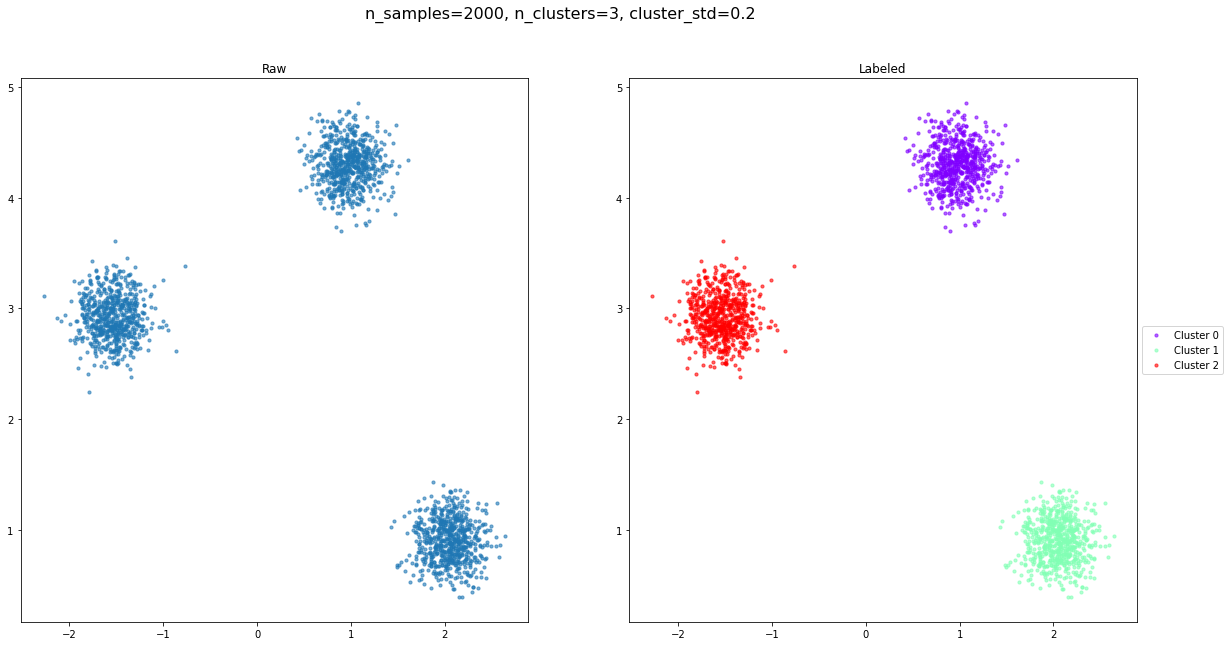

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973980
New total number of edges:  25020
Round time:  78.85821104049683
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21422
New total number of edges:  3598
Round time:  8.033411979675293
Total rounds of communication:  2
MST size:  1999
Created MST in:  93.61464357376099
Start creating clusters from MST...
Created clusters in:  0.02011418342590332
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       667
           1     1.0000    1.0000    1.0000       667
           2     1.0000    1.0000    1.0000       666

    accuracy                         1.0000      2000
   macro avg     1

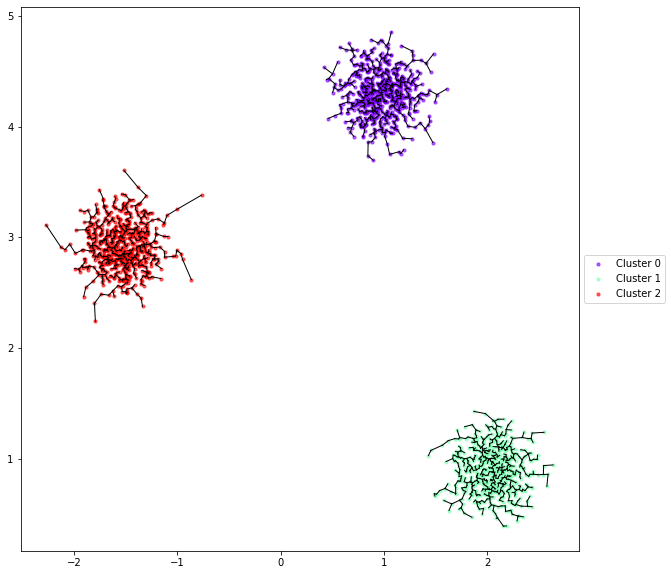

Start generating data...
Finished generating data.


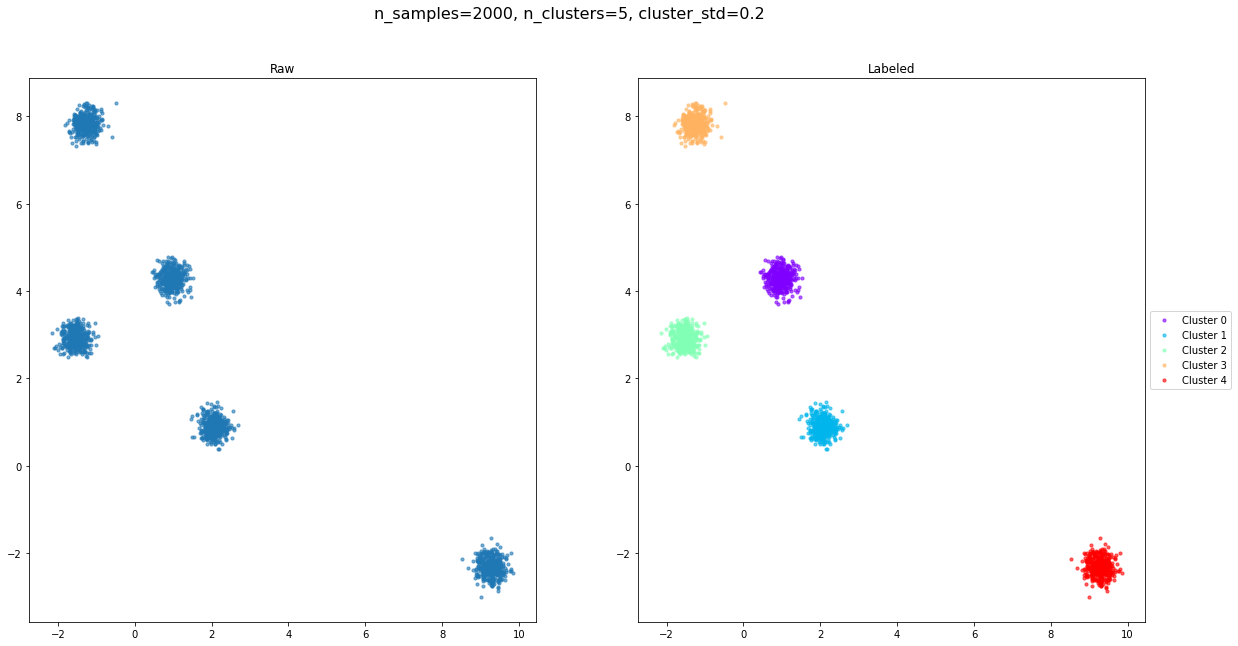

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973840
New total number of edges:  25160
Round time:  79.55100584030151
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21578
New total number of edges:  3582
Round time:  8.020448684692383
Total rounds of communication:  2
MST size:  1999
Created MST in:  94.47577214241028
Start creating clusters from MST...
Created clusters in:  0.042847633361816406
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       400
           1     1.0000    1.0000    1.0000       400
           2     1.0000    1.0000    1.0000       400
           3     1.0000    1.0000    1.0000       400
           4     1

Start generating data...
Finished generating data.


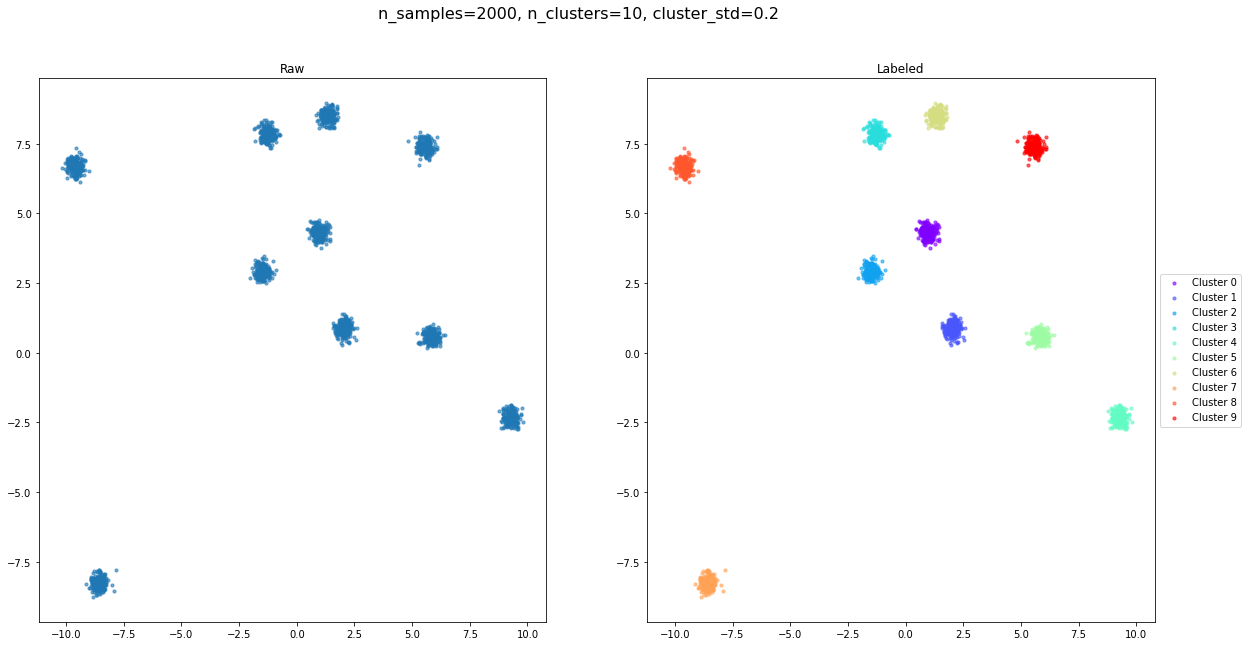

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1974474
New total number of edges:  24526
Round time:  67.4766309261322
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  20988
New total number of edges:  3538
Round time:  8.08165431022644
Total rounds of communication:  2
MST size:  1999
Created MST in:  85.11289310455322
Start creating clusters from MST...
Created clusters in:  0.08191108703613281
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       200
           1     1.0000    1.0000    1.0000       200
           2     1.0000    1.0000    1.0000       200
           3     1.0000    1.0000    1.0000       200
           4     1.00

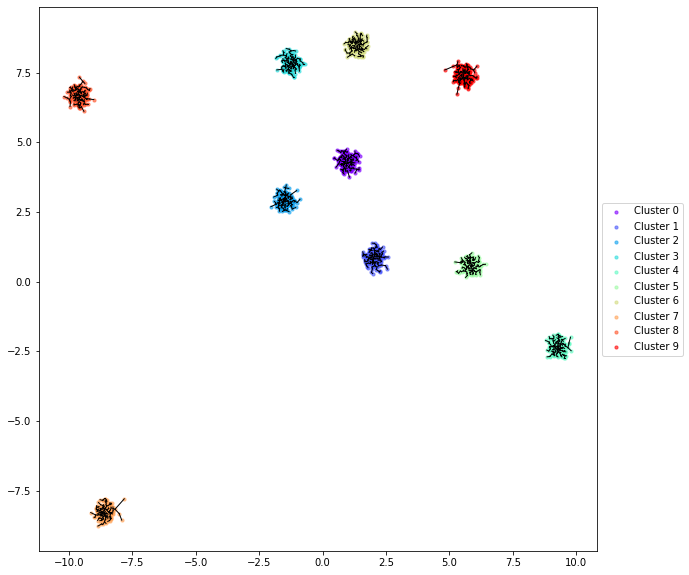

Start generating data...
Finished generating data.


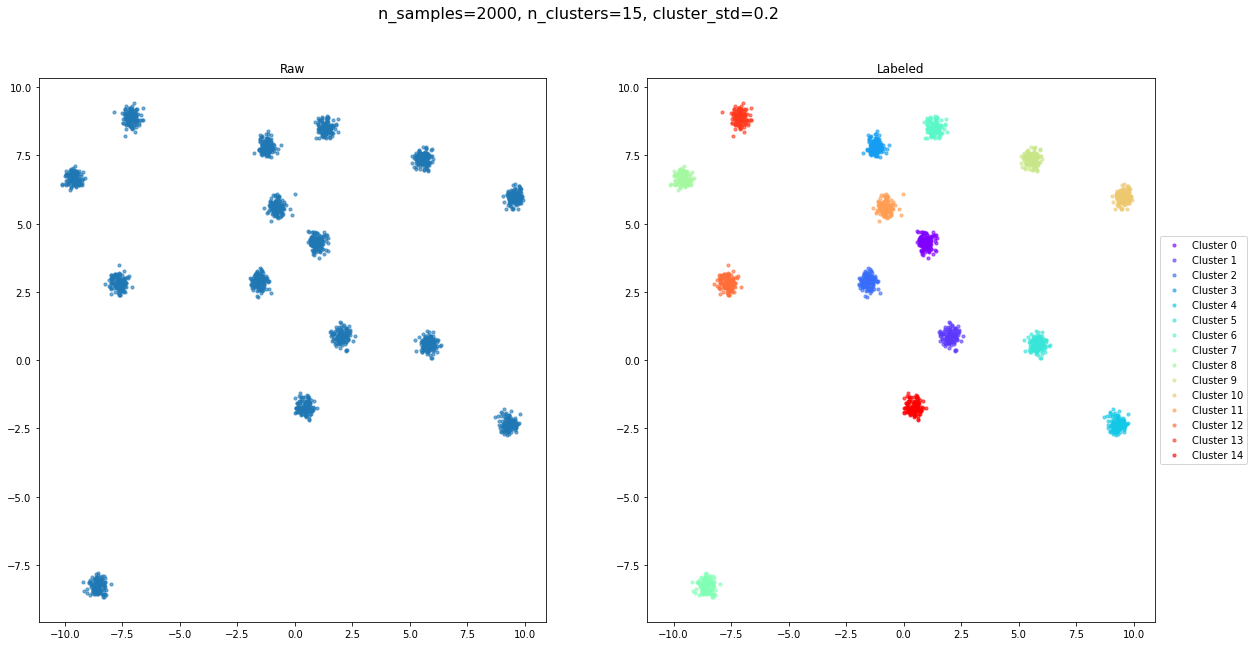

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1974843
New total number of edges:  24157
Round time:  61.830114126205444
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  20644
New total number of edges:  3513
Round time:  8.601656436920166
Total rounds of communication:  2
MST size:  1999
Created MST in:  80.11432981491089
Start creating clusters from MST...
Created clusters in:  0.12543773651123047
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       134
           1     1.0000    1.0000    1.0000       134
           2     1.0000    1.0000    1.0000       134
           3     1.0000    1.0000    1.0000       134
           4     1

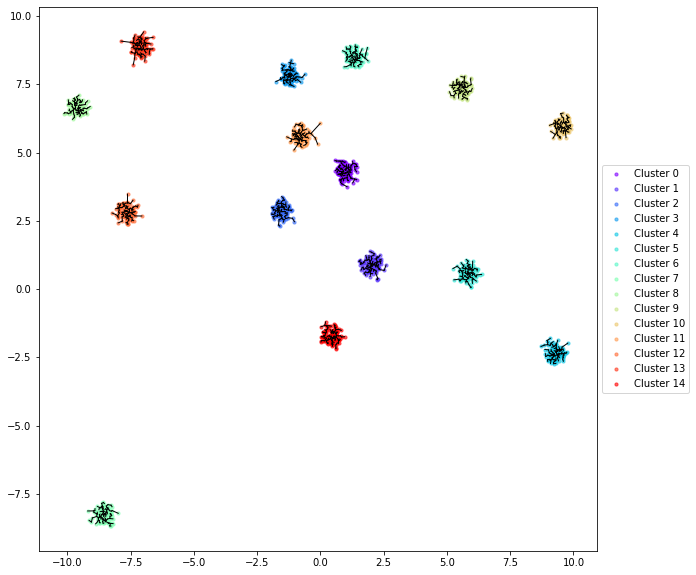

Start generating data...
Finished generating data.


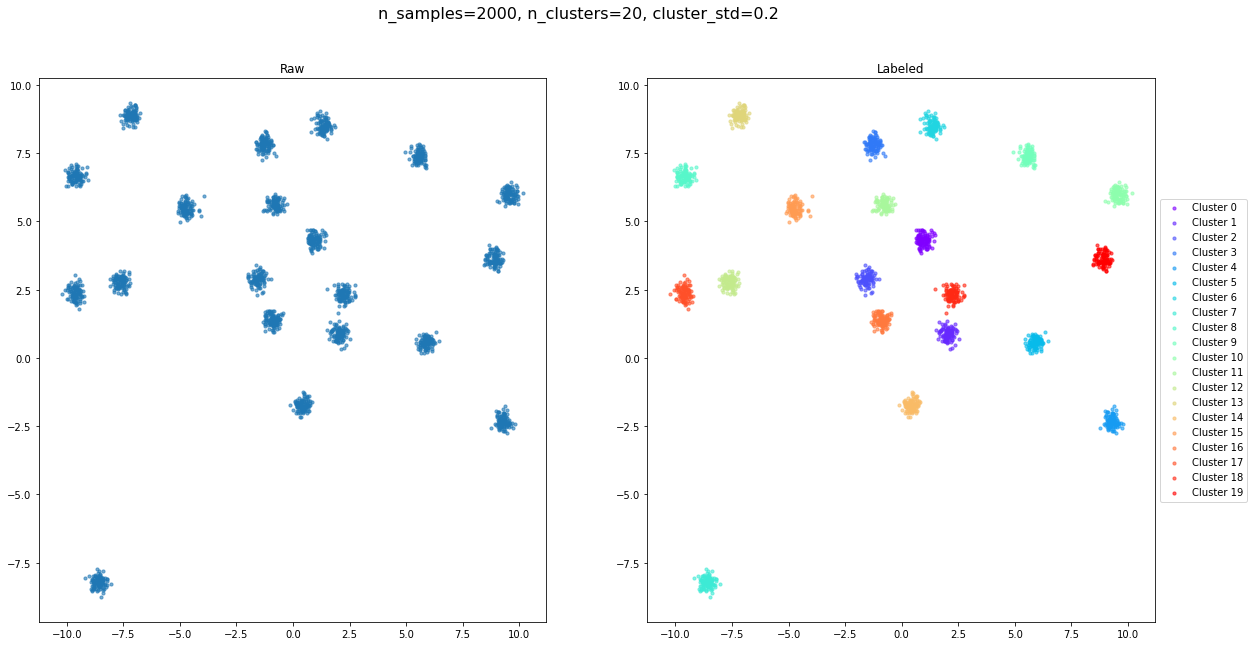

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1974979
New total number of edges:  24021
Round time:  55.87809634208679
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  20548
New total number of edges:  3473
Round time:  12.106733322143555
Total rounds of communication:  2
MST size:  1999
Created MST in:  74.78168416023254
Start creating clusters from MST...
Created clusters in:  0.35298633575439453
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       100
           1     1.0000    1.0000    1.0000       100
           2     1.0000    1.0000    1.0000       100
           3     1.0000    1.0000    1.0000       100
           4     1

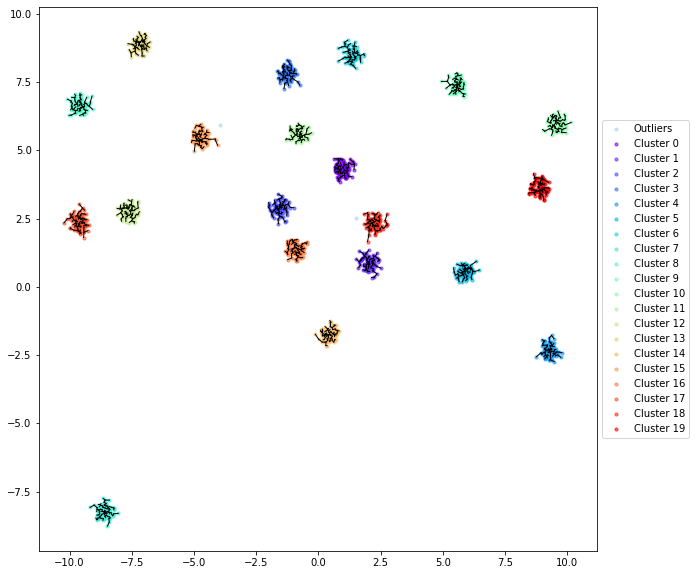

In [ ]:
stats = run_experiments(params)

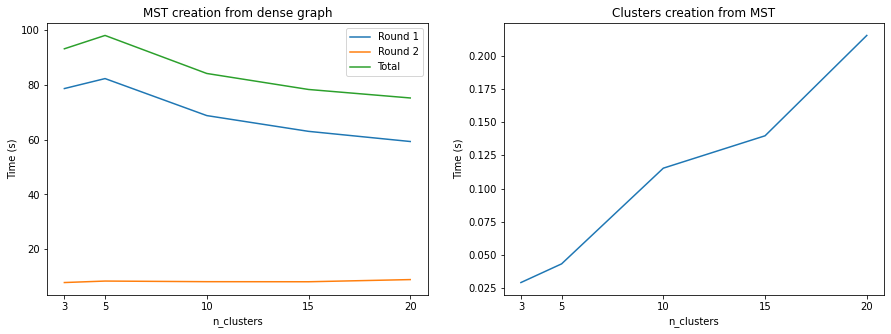

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_time_analysis(axes, stats, params)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_performance_analysis(ax, stats, params)
plt.show()

## Varying degree of overlap between clusters

In [ ]:
params = {
    'experiment': 'cluster_std',
    'n_samples': 2000,
    'n_clusters': 3,
    'cluster_std': [0.2, 0.4, 0.6, 0.8, 1.],
    'n_mst_runs': 10,
    'epsilon': 1/8,
    'min_cluster_size': 20
}

Start generating data...
Finished generating data.


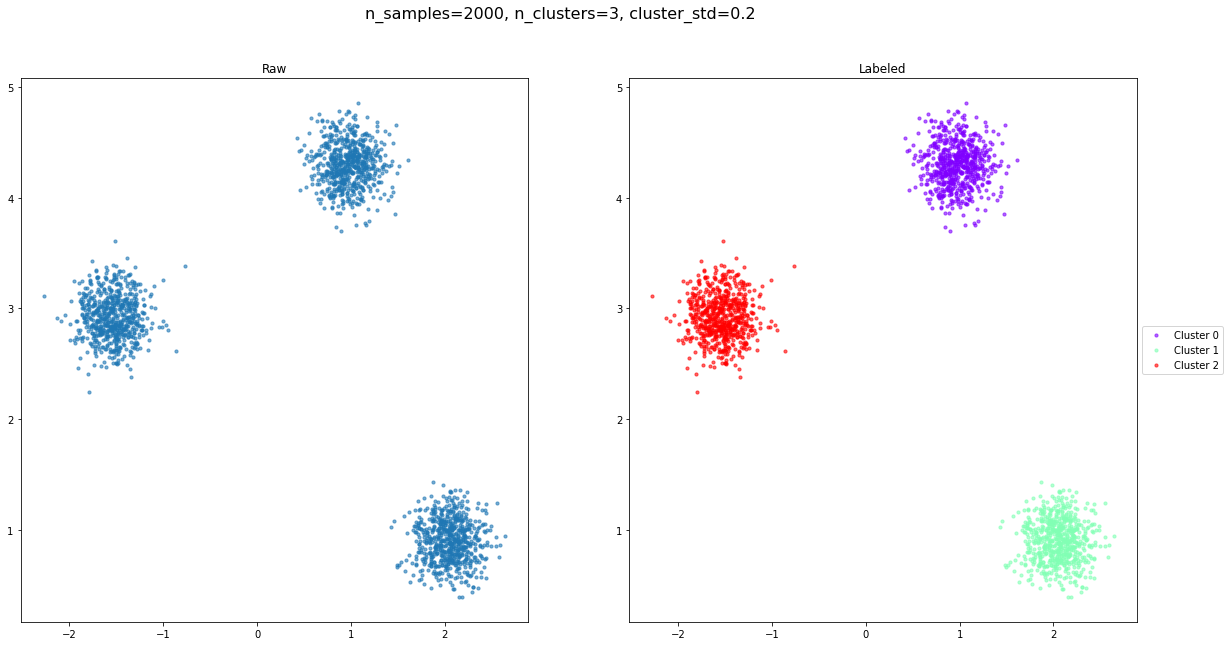

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973614
New total number of edges:  25386
Round time:  83.73035311698914
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21813
New total number of edges:  3573
Round time:  8.17876386642456
Total rounds of communication:  2
MST size:  1999
Created MST in:  98.82719898223877
Start creating clusters from MST...
Created clusters in:  0.021697044372558594
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       667
           1     1.0000    1.0000    1.0000       667
           2     1.0000    1.0000    1.0000       666

    accuracy                         1.0000      2000
   macro avg     1

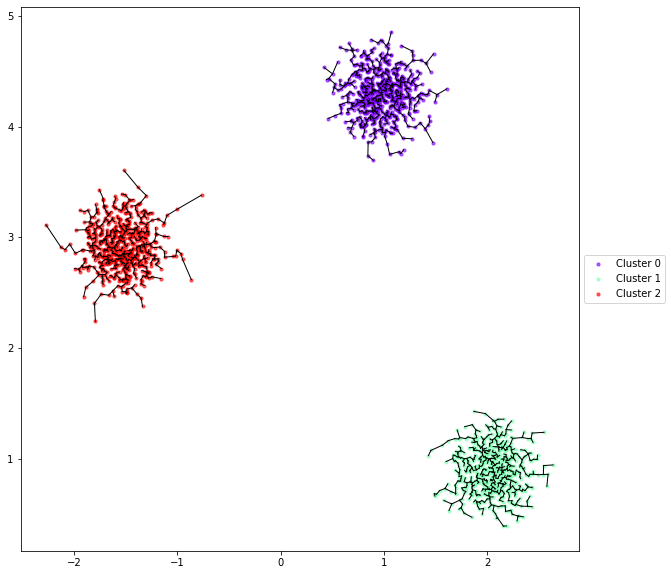

Start generating data...
Finished generating data.


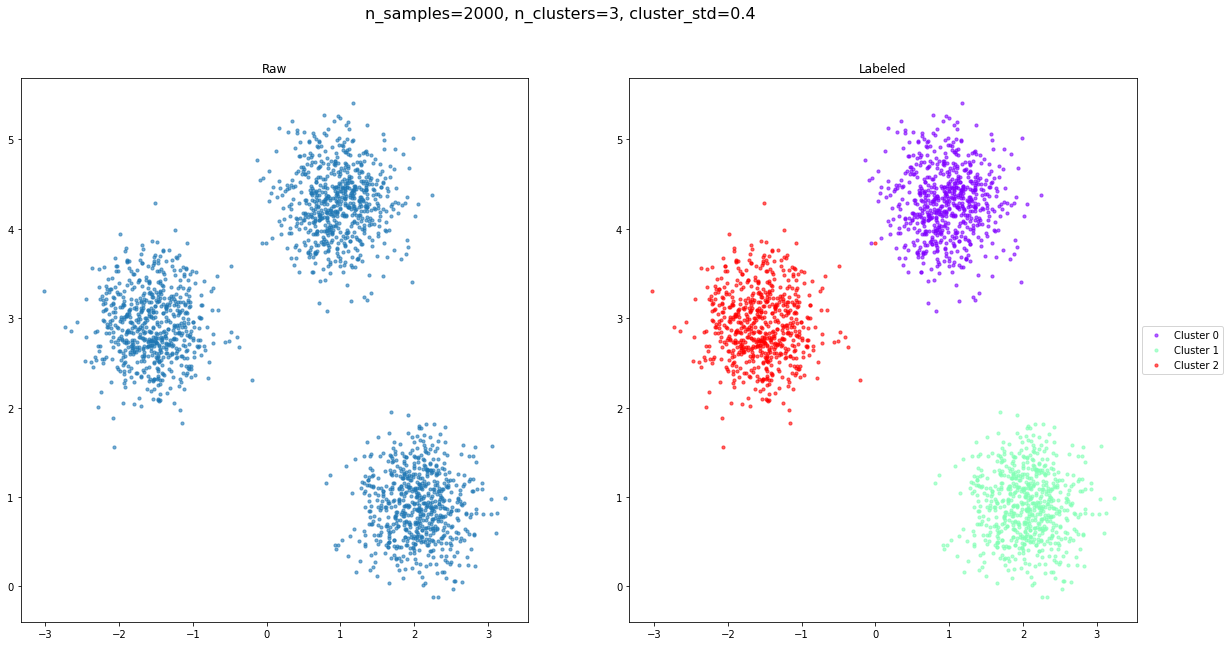

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973715
New total number of edges:  25285
Round time:  72.36225748062134
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21720
New total number of edges:  3565
Round time:  7.641294240951538
Total rounds of communication:  2
MST size:  1999
Created MST in:  86.87778520584106
Start creating clusters from MST...
Created clusters in:  0.03214597702026367
Clustering performance:
              precision    recall  f1-score   support

           0     0.9985    1.0000    0.9993       667
           1     1.0000    1.0000    1.0000       667
           2     1.0000    0.9970    0.9985       666

   micro avg     0.9995    0.9990    0.9992      2000
   macro avg     0

Start generating data...
Finished generating data.


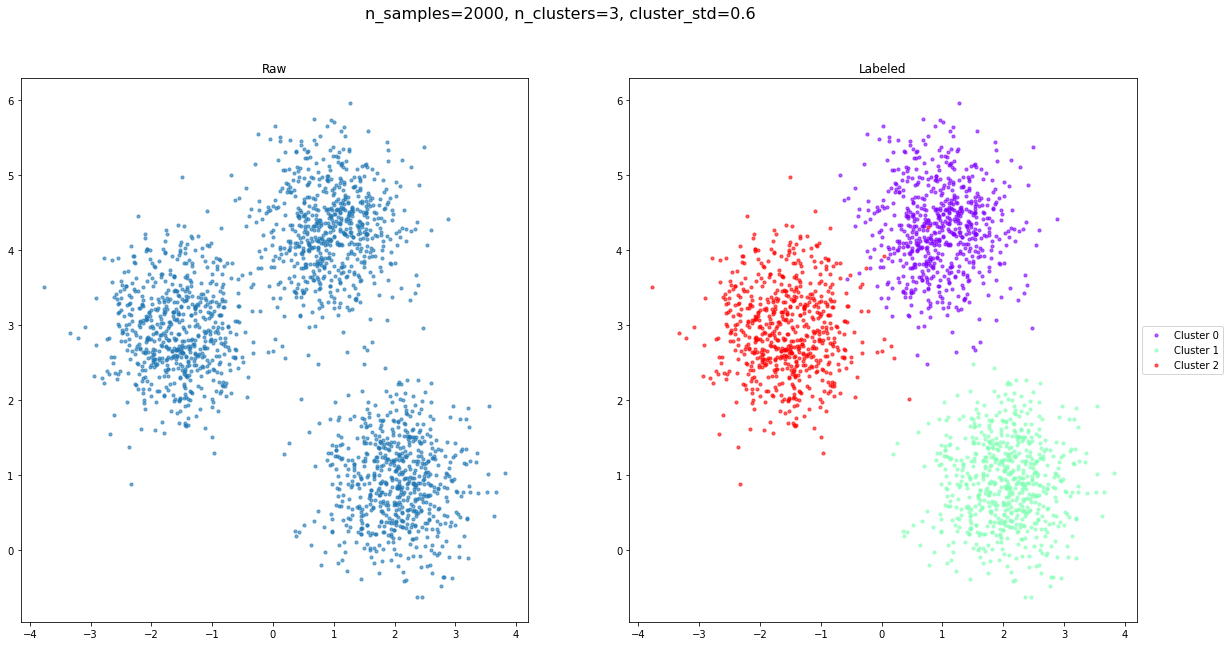

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973714
New total number of edges:  25286
Round time:  61.95620322227478
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21696
New total number of edges:  3590
Round time:  7.903607130050659
Total rounds of communication:  2
MST size:  1999
Created MST in:  76.69374513626099
Start creating clusters from MST...
Created clusters in:  1.2629990577697754
Clustering performance:
              precision    recall  f1-score   support

           0     0.9885    0.9040    0.9444       667
           1     1.0000    0.8951    0.9446       667
           2     1.0000    0.8994    0.9470       666

   micro avg     0.9961    0.8995    0.9453      2000
   macro avg     0.

Start generating data...
Finished generating data.


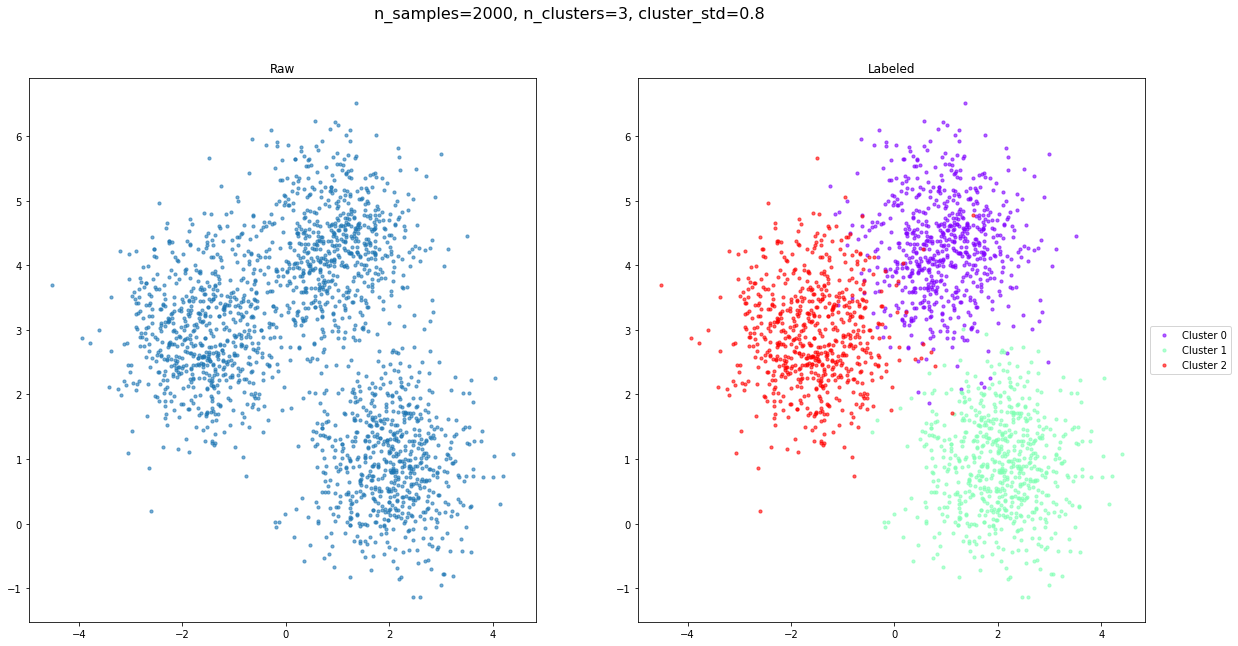

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973727
New total number of edges:  25273
Round time:  53.18441081047058
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21737
New total number of edges:  3536
Round time:  6.702220439910889
Total rounds of communication:  2
MST size:  1999
Created MST in:  66.94756770133972
Start creating clusters from MST...
Created clusters in:  1.855004072189331
Clustering performance:
              precision    recall  f1-score   support

           0     0.9785    0.7496    0.8489       667
           1     0.9873    0.8171    0.8942       667
           2     0.9683    0.8243    0.8905       666

   micro avg     0.9779    0.7970    0.8782      2000
   macro avg     0.9

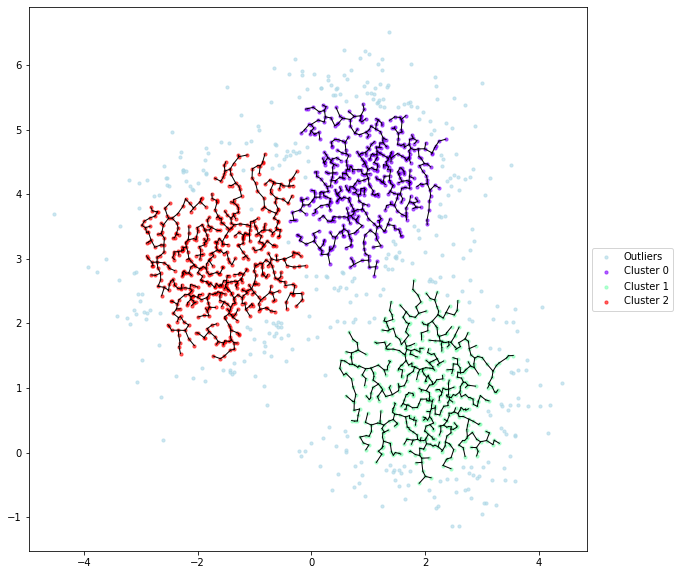

Start generating data...
Finished generating data.


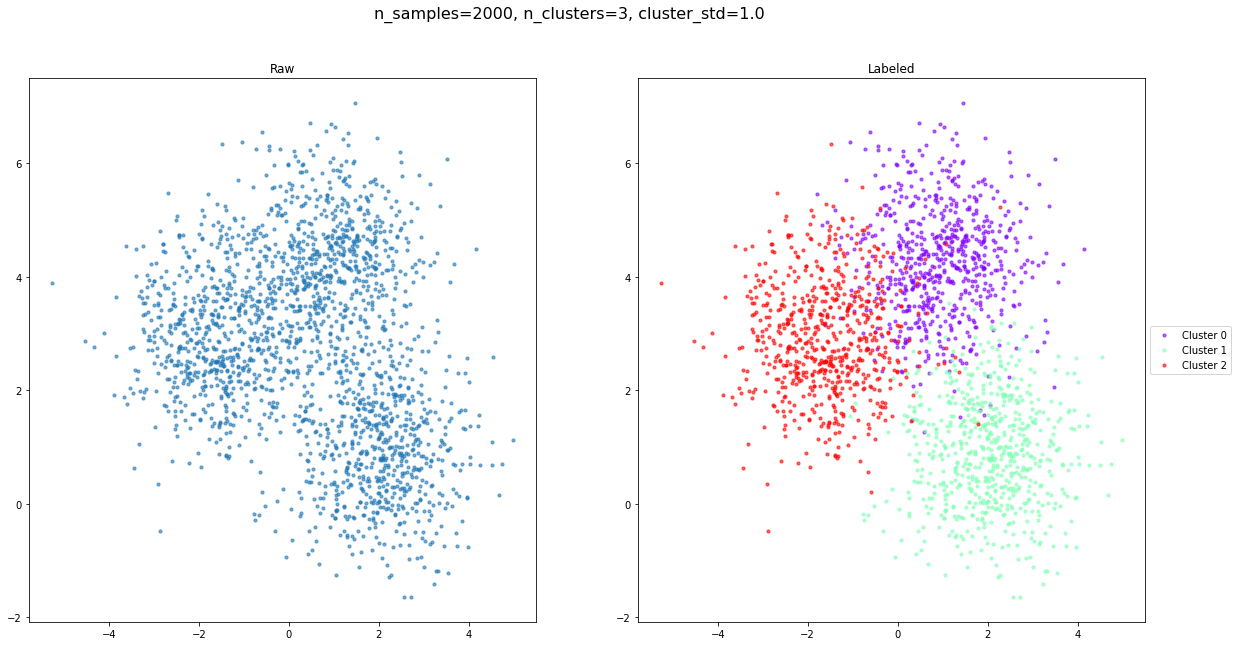

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973413
New total number of edges:  25587
Round time:  50.29496884346008
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  22008
New total number of edges:  3579
Round time:  5.855905771255493
Total rounds of communication:  2
MST size:  1999
Created MST in:  62.744152784347534
Start creating clusters from MST...
Created clusters in:  2.1438302993774414
Clustering performance:
              precision    recall  f1-score   support

           0     0.0513    0.0030    0.0057       667
           1     0.3208    0.6627    0.4323       667
           2     0.6000    0.0360    0.0680       666

   micro avg     0.3212    0.2340    0.2708      2000
   macro avg     0

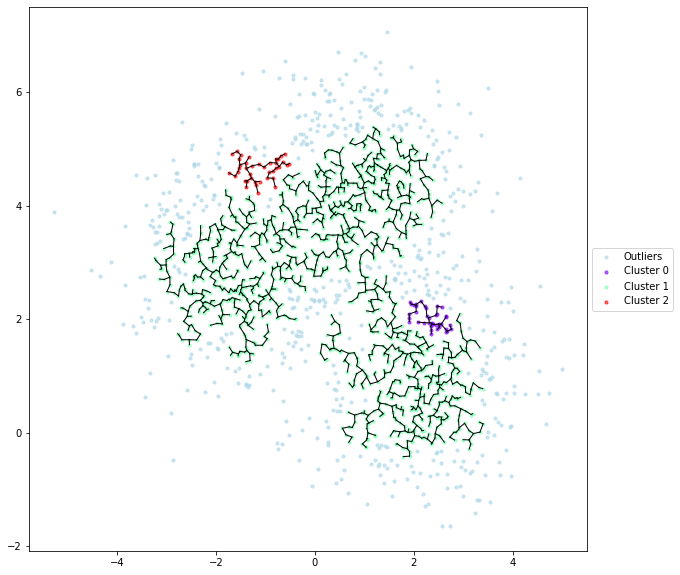

In [ ]:
stats = run_experiments(params)

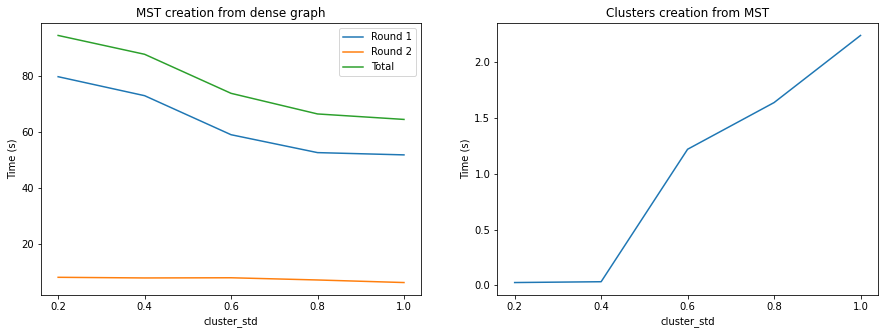

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_time_analysis(axes, stats, params)
plt.show()

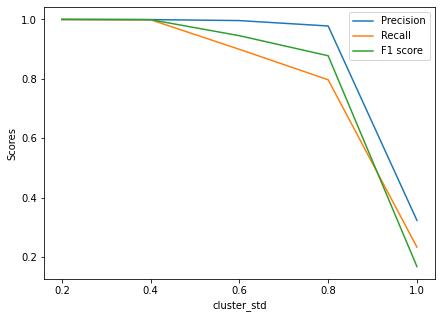

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_performance_analysis(ax, stats, params)
plt.show()

## Varying min_cluster_size

In [ ]:
params = {
    'experiment': 'min_cluster_size',
    'n_samples': 2000,
    'n_clusters': 3,
    'cluster_std': 0.8,
    'n_mst_runs': 10,
    'epsilon': 1/8,
    'min_cluster_size': [1, 5, 10, 15, 20]
}

Start generating data...
Finished generating data.


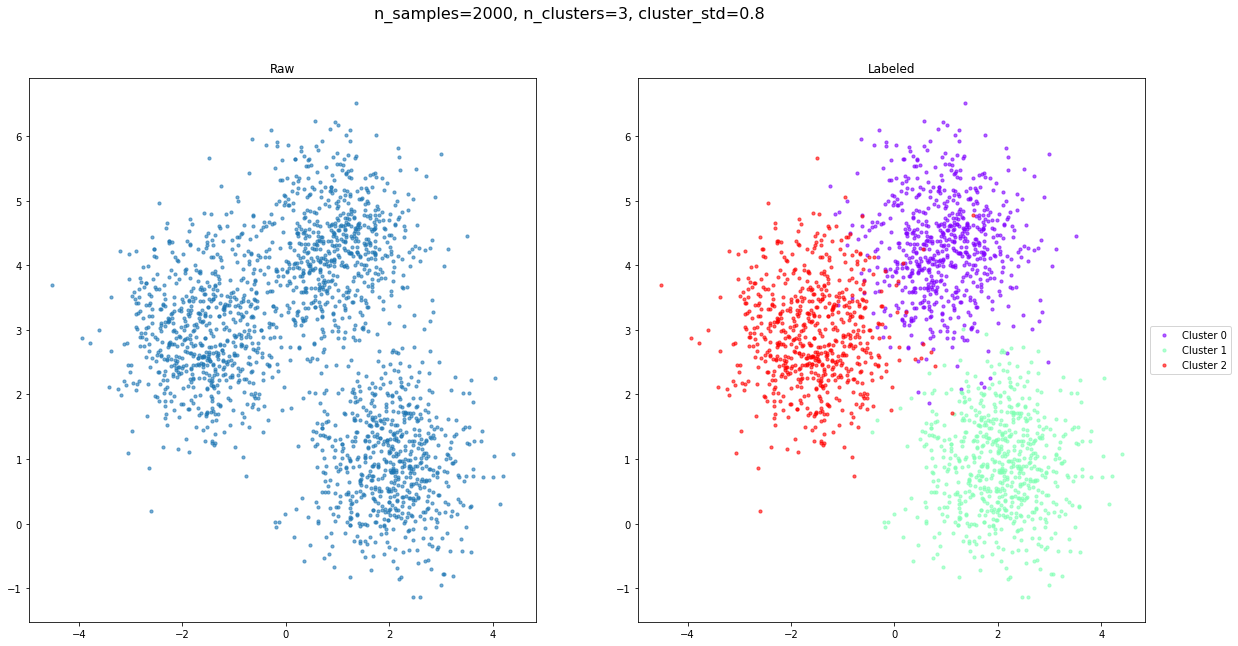

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973487
New total number of edges:  25513
Round time:  51.31327486038208
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21913
New total number of edges:  3600
Round time:  6.420400142669678
Total rounds of communication:  2
MST size:  1999
Created MST in:  64.54421401023865
Start creating clusters from MST...
Created clusters in:  0.14919781684875488
Clustering performance:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       667
           1     0.3343    0.9940    0.5004       667
           2     1.0000    0.0045    0.0090       666

   micro avg     0.3350    0.3330    0.3340      2000
   macro avg     0

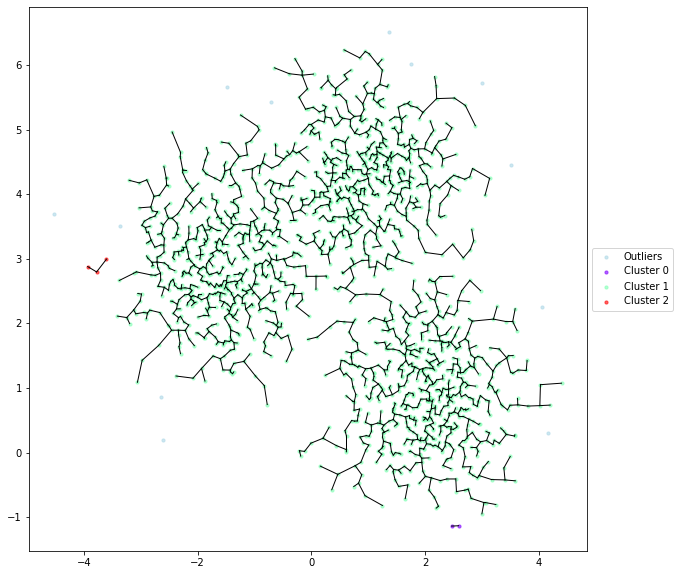

Start generating data...
Finished generating data.


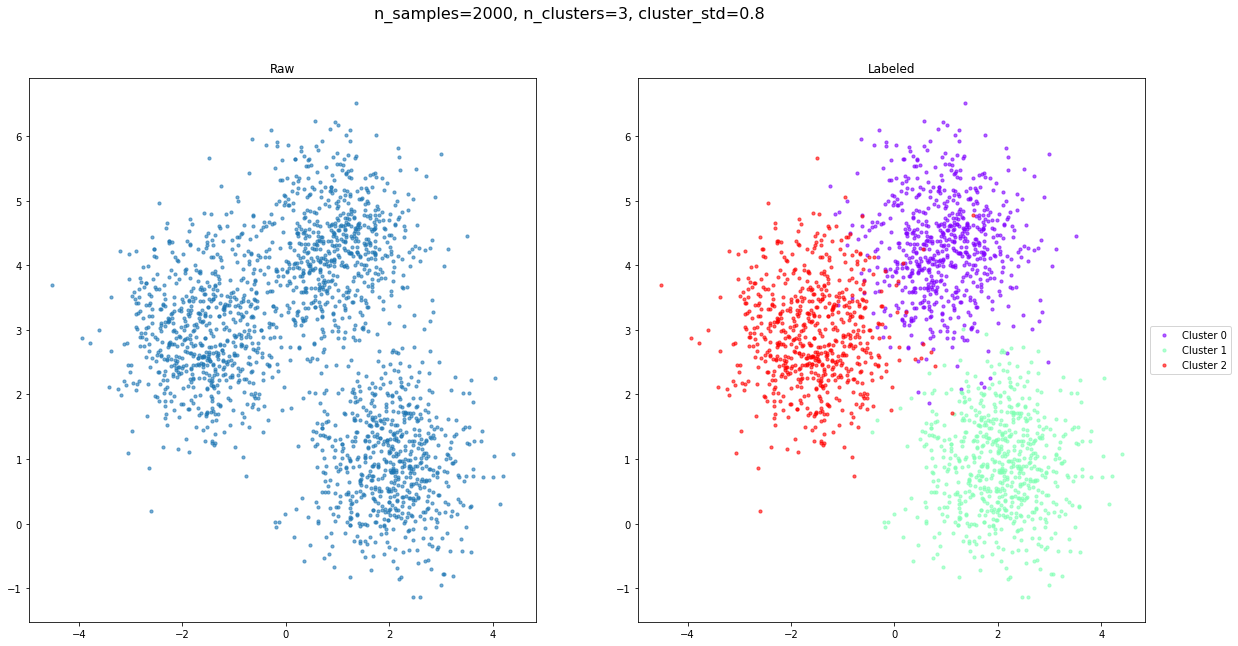

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973549
New total number of edges:  25451
Round time:  52.8102605342865
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21883
New total number of edges:  3568
Round time:  6.816304445266724
Total rounds of communication:  2
MST size:  1999
Created MST in:  66.66016793251038
Start creating clusters from MST...
Created clusters in:  0.2915995121002197
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    0.0075    0.0149       667
           1     0.3325    0.9760    0.4960       667
           2     0.0000    0.0000    0.0000       666

   micro avg     0.3332    0.3280    0.3306      2000
   macro avg     0.4

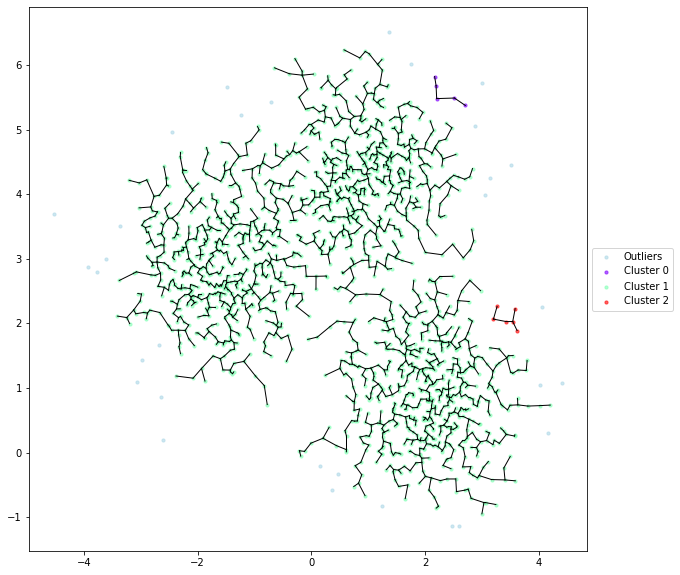

Start generating data...
Finished generating data.


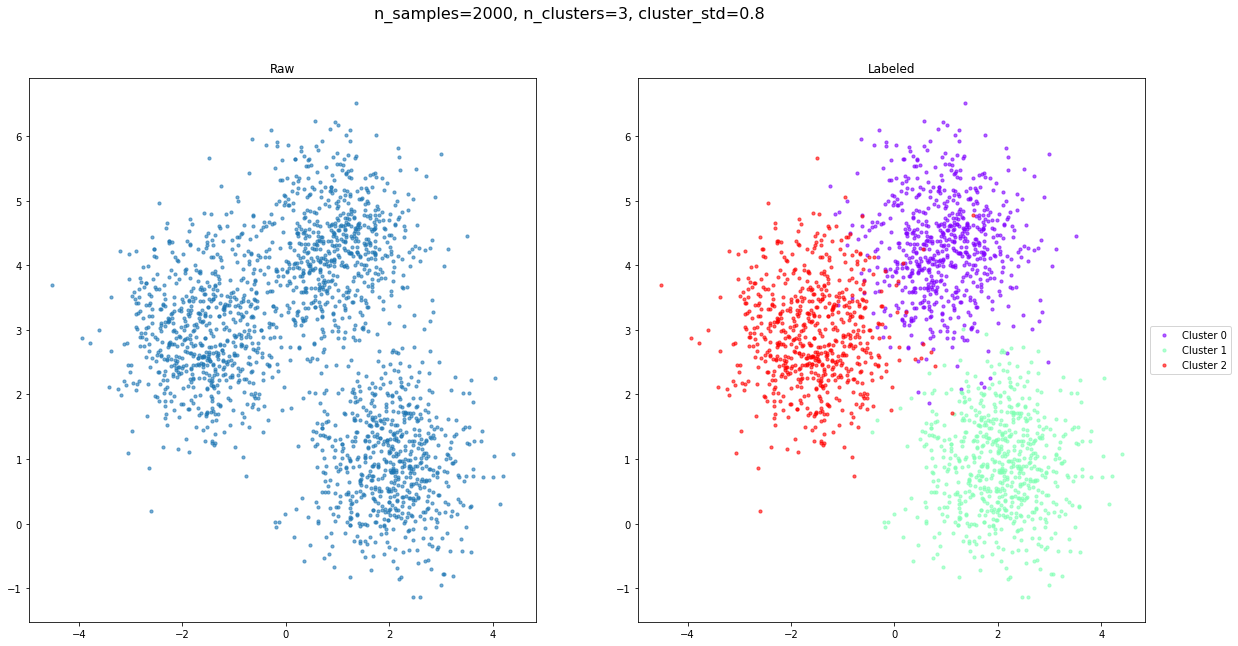

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973666
New total number of edges:  25334
Round time:  52.45199751853943
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21748
New total number of edges:  3586
Round time:  6.5857274532318115
Total rounds of communication:  2
MST size:  1999
Created MST in:  65.94320154190063
Start creating clusters from MST...
Created clusters in:  0.4725821018218994
Clustering performance:
              precision    recall  f1-score   support

           0     0.5016    0.9490    0.6563       667
           1     0.9844    0.9490    0.9664       667
           2     1.0000    0.0195    0.0383       666

   micro avg     0.6668    0.6395    0.6529      2000
   macro avg     0

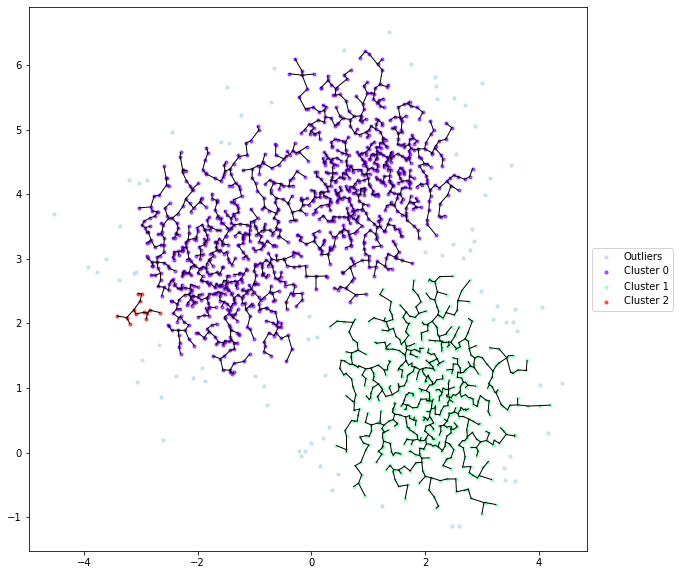

Start generating data...
Finished generating data.


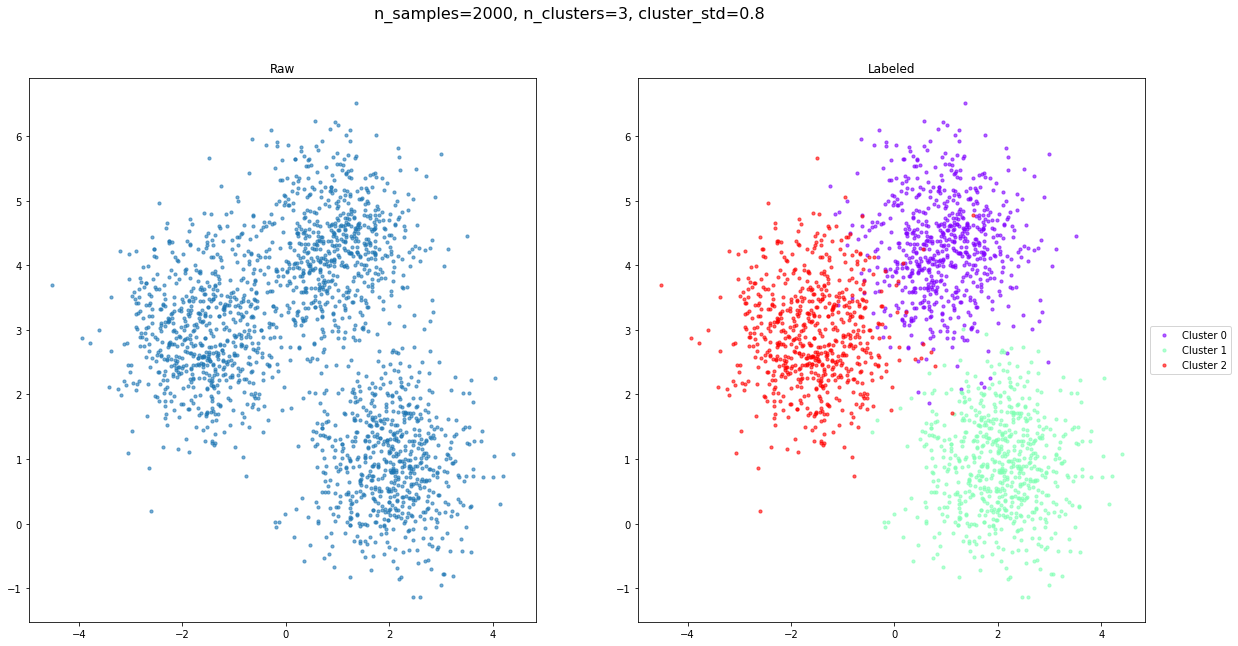

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973451
New total number of edges:  25549
Round time:  52.59684681892395
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21960
New total number of edges:  3589
Round time:  6.676788568496704
Total rounds of communication:  2
MST size:  1999
Created MST in:  66.13248348236084
Start creating clusters from MST...
Created clusters in:  1.157116413116455
Clustering performance:
              precision    recall  f1-score   support

           0     1.0000    0.0240    0.0469       667
           1     0.9847    0.8681    0.9227       667
           2     0.5046    0.9039    0.6477       666

   micro avg     0.6661    0.5985    0.6305      2000
   macro avg     0.8

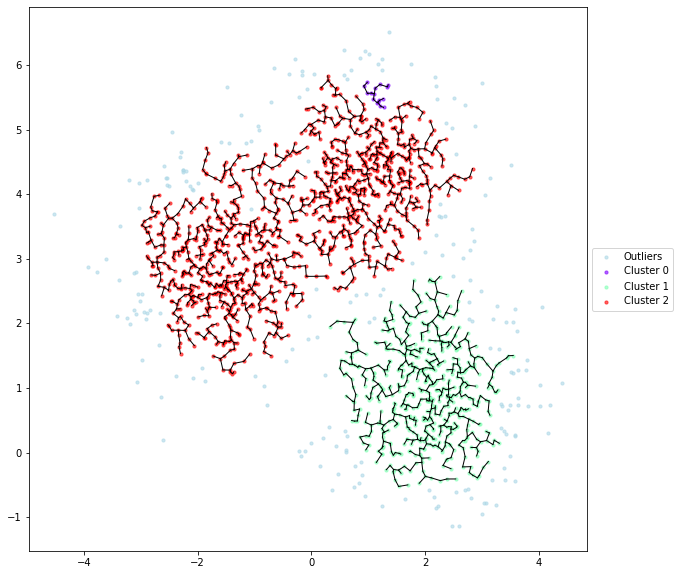

Start generating data...
Finished generating data.


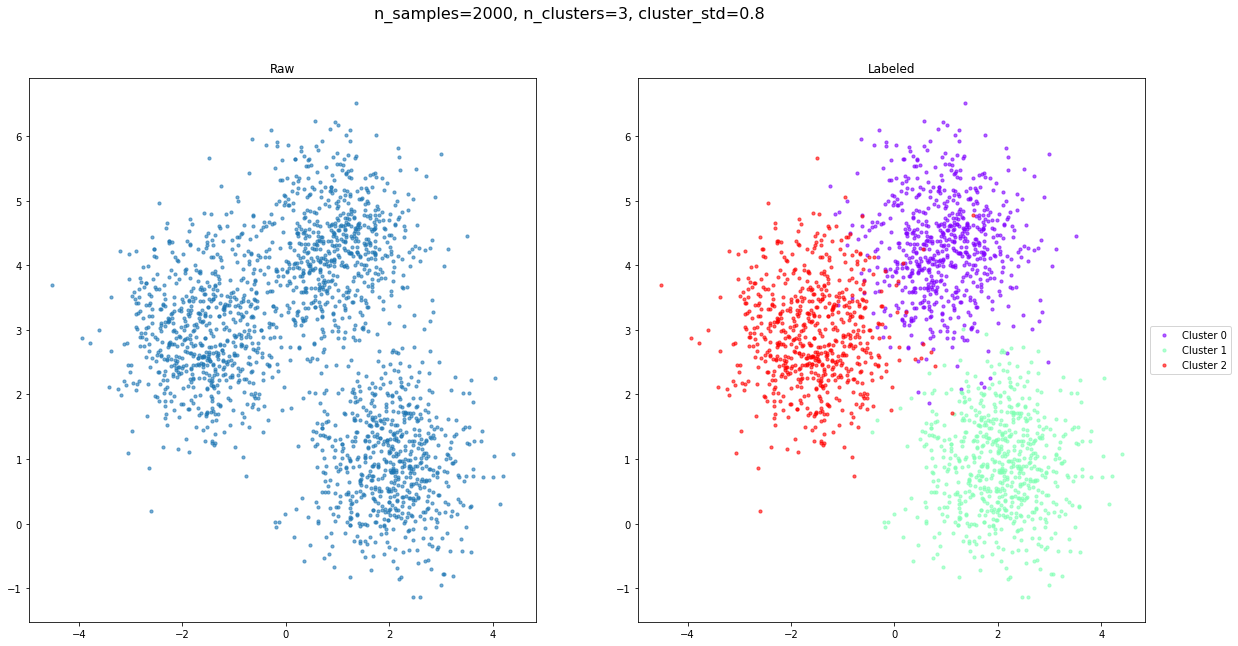

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973616
New total number of edges:  25384
Round time:  53.50515532493591
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21793
New total number of edges:  3591
Round time:  7.014432191848755
Total rounds of communication:  2
MST size:  1999
Created MST in:  67.41074085235596
Start creating clusters from MST...
Created clusters in:  1.6841404438018799
Clustering performance:
              precision    recall  f1-score   support

           0     0.9785    0.7496    0.8489       667
           1     0.9873    0.8171    0.8942       667
           2     0.9683    0.8243    0.8905       666

   micro avg     0.9779    0.7970    0.8782      2000
   macro avg     0.

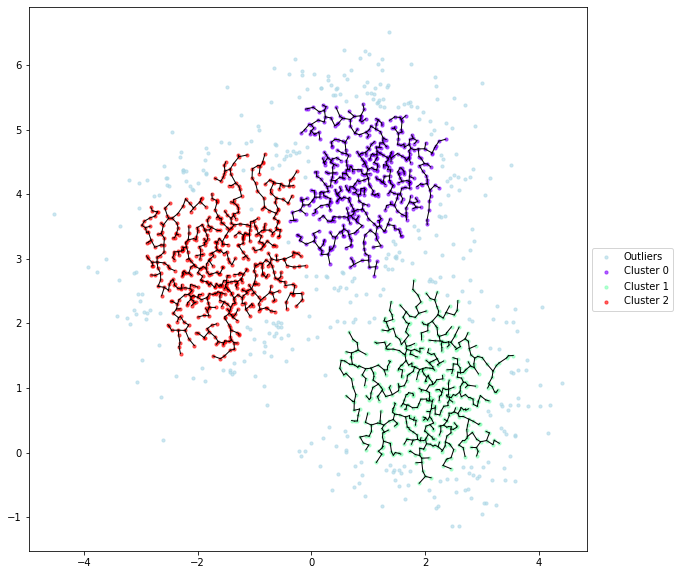

In [ ]:
stats = run_experiments(params)

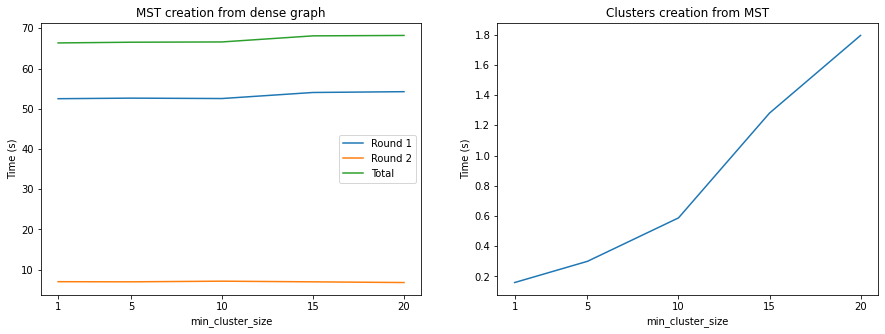

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_time_analysis(axes, stats, params)
plt.show()

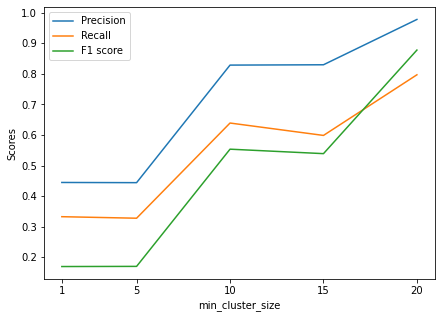

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_performance_analysis(ax, stats, params)
plt.show()

## Varying min_cluster_size++

In [23]:
params = {
    'experiment': 'min_cluster_size',
    'n_samples': 2000,
    'n_clusters': 3,
    'cluster_std': 0.8,
    'n_mst_runs': 10,
    'epsilon': 1/8,
    'min_cluster_size': [25, 50, 100]
}

Start generating data...
Finished generating data.


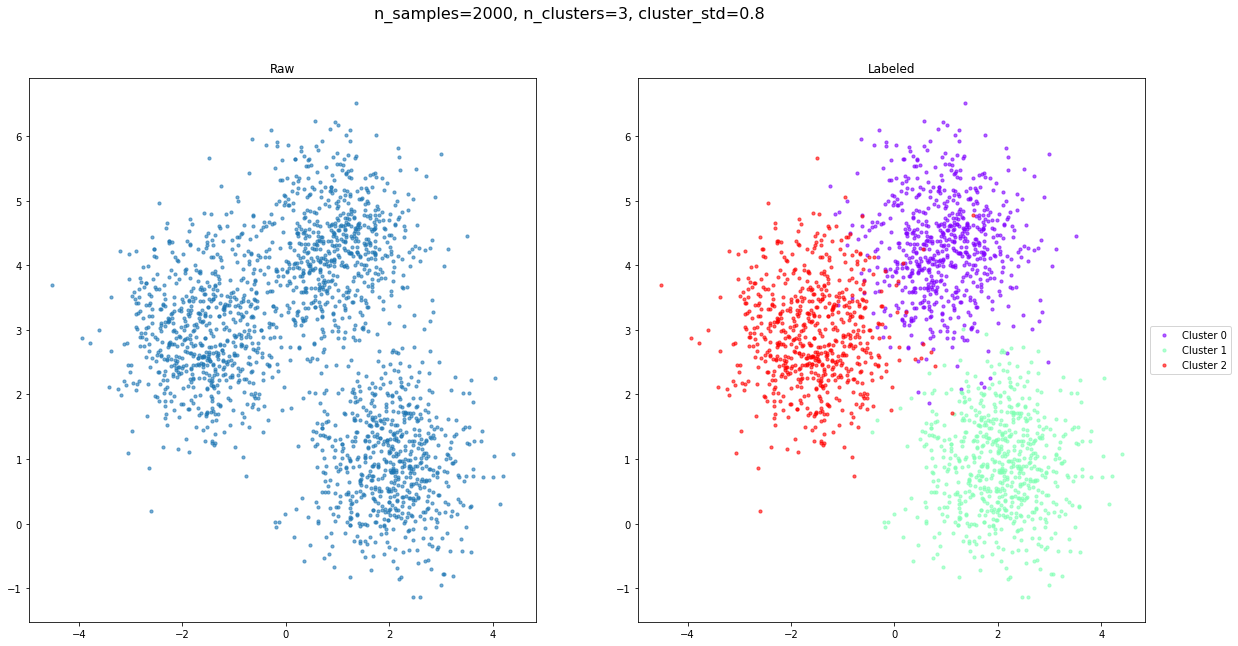

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973715
New total number of edges:  25285
Round time:  71.68312406539917
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21705
New total number of edges:  3580
Round time:  8.17746639251709
Total rounds of communication:  2
MST size:  1999
Created MST in:  87.12677717208862
Start creating clusters from MST...
Created clusters in:  2.477848768234253
Clustering performance:
              precision    recall  f1-score   support

           0     0.9785    0.7496    0.8489       667
           1     0.9873    0.8171    0.8942       667
           2     0.9683    0.8243    0.8905       666

   micro avg     0.9779    0.7970    0.8782      2000
   macro avg     0.97

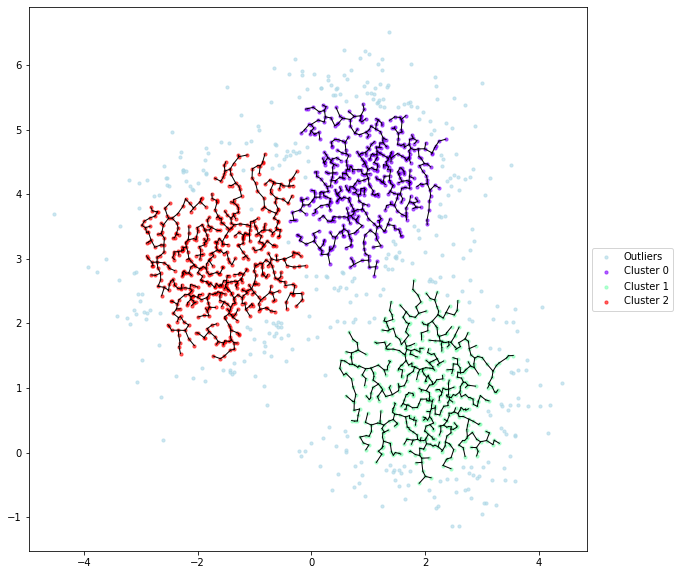

Start generating data...
Finished generating data.


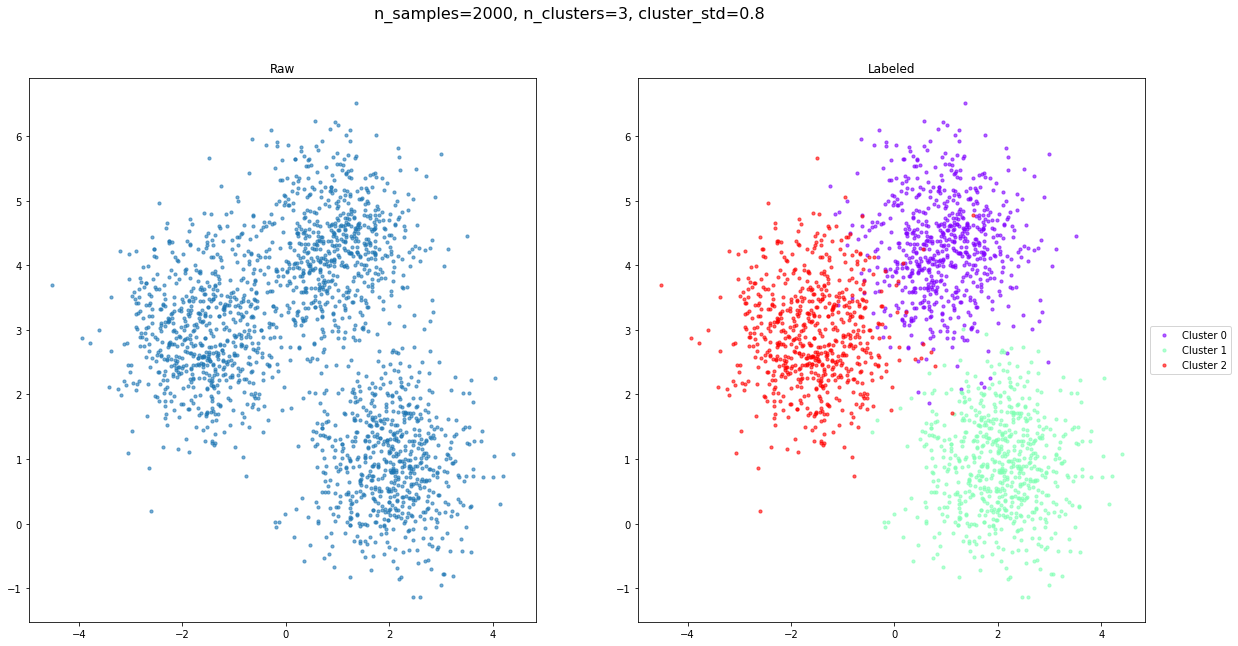

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973587
New total number of edges:  25413
Round time:  57.231518030166626
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21855
New total number of edges:  3558
Round time:  7.840298414230347
Total rounds of communication:  2
MST size:  1999
Created MST in:  73.07209777832031
Start creating clusters from MST...
Created clusters in:  2.2569100856781006
Clustering performance:
              precision    recall  f1-score   support

           0     0.9785    0.7496    0.8489       667
           1     0.9873    0.8171    0.8942       667
           2     0.9683    0.8243    0.8905       666

   micro avg     0.9779    0.7970    0.8782      2000
   macro avg     0

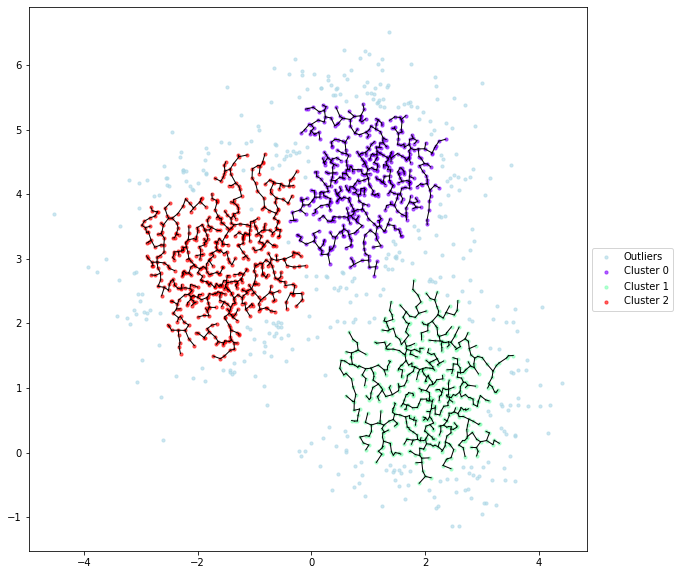

Start generating data...
Finished generating data.


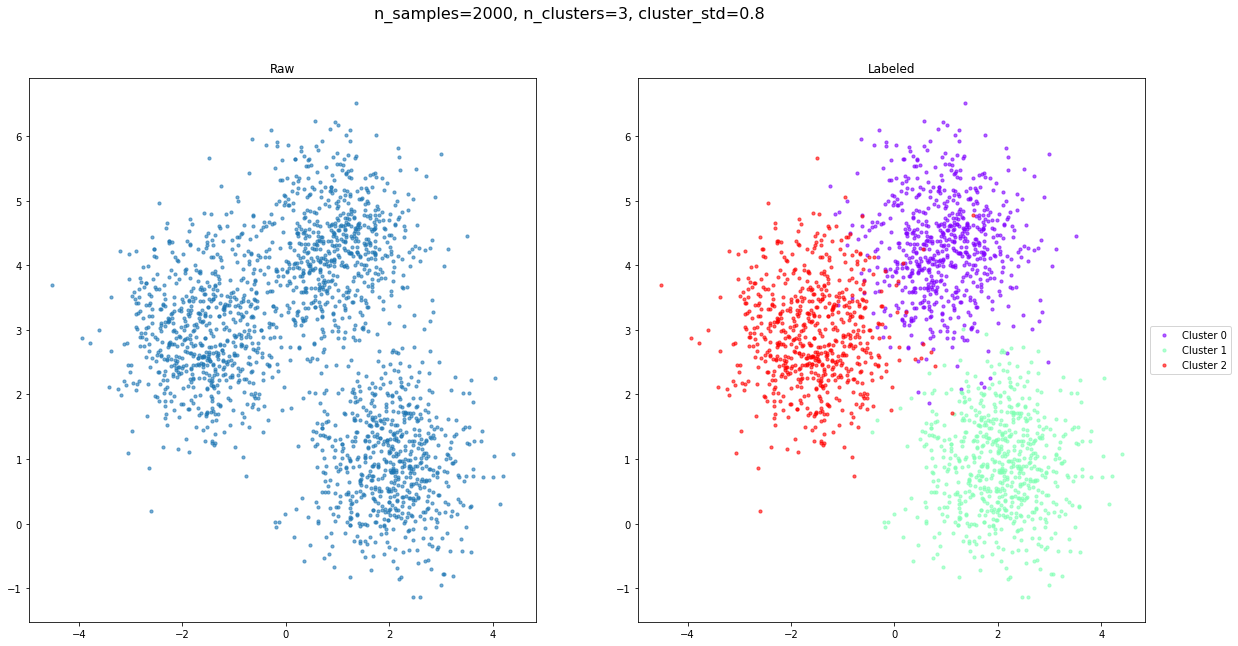

Start creating dense graph...
Number of vertices:  2000
Number of edges:  1999000
Finished creating dense graph.
=====
Run:  0
Start creating MST...
Communication round:  1
c:  0.9087414541505094
Number of buckets:  20
Total number of edges removed in this round:  1973775
New total number of edges:  25225
Round time:  57.70703458786011
Communication round:  2
c:  0.3918707270752547
Number of buckets:  3
Total number of edges removed in this round:  21645
New total number of edges:  3580
Round time:  7.3088483810424805
Total rounds of communication:  2
MST size:  1999
Created MST in:  72.52055978775024
Start creating clusters from MST...
Created clusters in:  2.3735318183898926
Clustering performance:
              precision    recall  f1-score   support

           0     0.9785    0.7496    0.8489       667
           1     0.9873    0.8171    0.8942       667
           2     0.9683    0.8243    0.8905       666

   micro avg     0.9779    0.7970    0.8782      2000
   macro avg     0

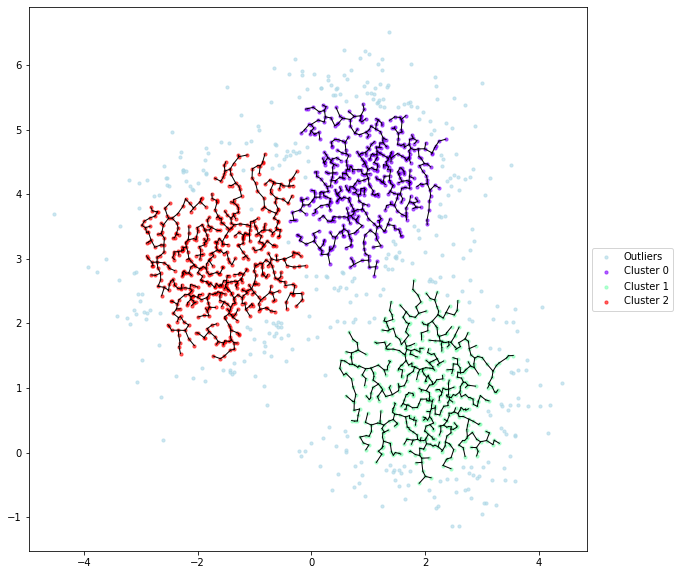

In [24]:
stats = run_experiments(params)

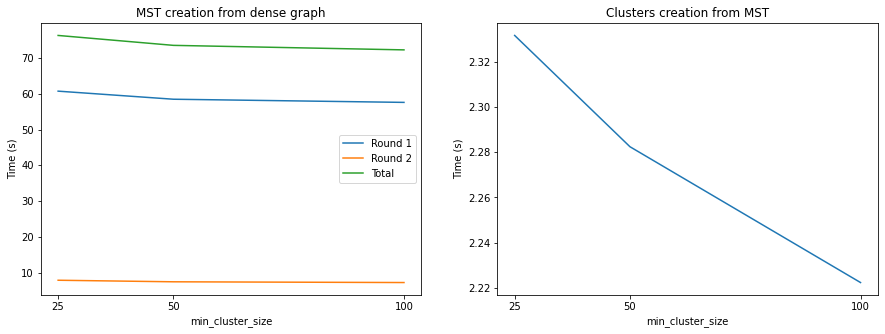

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_time_analysis(axes, stats, params)
plt.show()

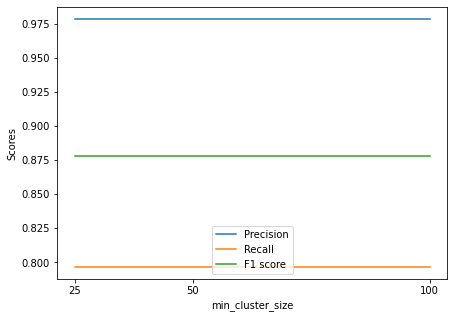

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_performance_analysis(ax, stats, params)
plt.show()